<a href="https://colab.research.google.com/github/erskinekof/erskinekof.github.io/blob/master/SamErskAnomalyDetction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense

# --- 1. Data Loading and Initial Exploration ---

# Define column names for the KDD Cup 99 dataset
col_names = [
    "duration", "protocol_type", "service", "flag", "src_bytes",
    "dst_bytes", "land", "wrong_fragment", "urgent", "hot",
    "num_failed_logins", "logged_in", "num_compromised", "root_shell",
    "su_attempted", "num_root", "num_file_creations", "num_shells",
    "num_access_files", "num_outbound_cmds", "is_host_login",
    "is_guest_login", "count", "srv_count", "serror_rate",
    "srv_serror_rate", "rerror_rate", "srv_rerror_rate", "same_srv_rate",
    "diff_srv_rate", "srv_diff_host_rate", "dst_host_count",
    "dst_host_srv_count", "dst_host_same_srv_rate", "dst_host_diff_srv_rate",
    "dst_host_same_src_port_rate", "dst_host_srv_diff_host_rate",
    "dst_host_serror_rate", "dst_host_srv_serror_rate",
    "dst_host_rerror_rate", "dst_host_srv_rerror_rate", "label"
]

# Load the dataset
try:
    df = pd.read_csv('/content/CICIoT2023Dataset1.csv', header=None, names=col_names, low_memory=False)
    print("Dataset loaded successfully.")
    print(f"Dataset shape: {df.shape}")
except FileNotFoundError:
    print("Error: 'corrected.gz' not found.")
    print("Please download the KDD Cup 1999 'corrected.gz' file and place it in the same directory as this script.")
    data = {name: np.random.rand(1000) for name in col_names if name not in ["protocol_type", "service", "flag", "label"]}
    data["protocol_type"] = np.random.choice(['tcp', 'udp', 'icmp'], 1000)
    data["service"] = np.random.choice(['http', 'smtp', 'ftp_data', 'eco_i'], 1000)

Error: 'corrected.gz' not found.
Please download the KDD Cup 1999 'corrected.gz' file and place it in the same directory as this script.


In [ ]:
# --- 2. Data Preprocessing ---

# Display basic information about the dataframe
print("Dataframe Info:")
df.info()

# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())

# Display statistical summary
print("\nStatistical Summary:")
display(df.describe())

Dataframe Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 40 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   duration                     1000 non-null   float64
 1   src_bytes                    1000 non-null   float64
 2   dst_bytes                    1000 non-null   float64
 3   land                         1000 non-null   float64
 4   wrong_fragment               1000 non-null   float64
 5   urgent                       1000 non-null   float64
 6   hot                          1000 non-null   float64
 7   num_failed_logins            1000 non-null   float64
 8   logged_in                    1000 non-null   float64
 9   num_compromised              1000 non-null   float64
 10  root_shell                   1000 non-null   float64
 11  su_attempted                 1000 non-null   float64
 12  num_root                     1000 non-null   float64
 13  num

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,...,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.505985,0.497999,0.495601,0.509121,0.493345,0.484372,0.514490,0.495510,0.494171,0.516204,...,0.485619,0.492038,0.491605,0.501983,0.500757,0.499958,0.477396,0.494081,0.502131,0.495270
std,0.289119,0.278133,0.294344,0.286520,0.288738,0.291401,0.281166,0.280296,0.285129,0.288252,...,0.285849,0.287688,0.288494,0.291378,0.292193,0.289198,0.290638,0.289628,0.293286,0.293866
min,0.000378,0.002764,0.002597,0.001456,0.000016,0.000935,0.001387,0.002646,0.001788,0.001009,...,0.000189,0.000513,0.000519,0.000021,0.000471,0.003170,0.001130,0.000302,0.000052,0.000495
25%,0.248923,0.262714,0.226181,0.256743,0.236615,0.228693,0.279110,0.254895,0.248947,0.272797,...,0.251811,0.254618,0.253309,0.253207,0.232701,0.248403,0.211707,0.247331,0.254307,0.238420
50%,0.511878,0.494837,0.497153,0.515881,0.502832,0.466555,0.533348,0.484052,0.482324,0.522298,...,0.462760,0.483726,0.492506,0.499938,0.504596,0.493530,0.478541,0.480283,0.501500,0.489098
75%,0.748262,0.740238,0.755183,0.765873,0.739741,0.737860,0.749039,0.734042,0.738489,0.761062,...,0.730750,0.744780,0.736381,0.770743,0.756503,0.760697,0.729274,0.751811,0.765797,0.758125
max,0.996107,0.998857,0.999662,0.997487,0.999881,0.999819,0.999313,0.999813,0.996951,0.999620,...,0.999665,0.997875,0.998834,0.999443,0.999305,0.998294,0.999784,0.998540,0.999263,0.996904


In [ ]:
# --- 3. Feature Engineering ---

# One-hot encode categorical features
df = pd.get_dummies(df, columns=['protocol_type', 'service'], drop_first=True)

print("Categorical features encoded.")
display(df.head())

Categorical features encoded.


,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,protocol_type_tcp,protocol_type_udp,service_ftp_data,service_http,service_smtp
0,0.952835,0.809689,0.817808,0.576681,0.145719,0.926766,0.323974,0.479877,0.131070,0.064705,...,0.722992,0.602981,0.868970,0.966548,0.617046,False,True,False,False,False
1,0.088475,0.084227,0.297235,0.393142,0.168679,0.588200,0.038630,0.674069,0.309719,0.423927,...,0.849448,0.134834,0.679728,0.651736,0.052727,False,False,False,False,False
2,0.566443,0.480926,0.465806,0.386616,0.417268,0.203782,0.322751,0.756791,0.419734,0.089885,...,0.611110,0.111258,0.204455,0.339994,0.932960,False,True,True,False,False
3,0.788923,0.115222,0.071173,0.880395,0.063231,0.398189,0.585180,0.085920,0.398383,0.095080,...,0.523224,0.880430,0.467303,0.534258,0.017665,False,False,False,False,True
4,0.781400,0.625432,0.387462,0.626013,0.425803,0.994769,0.441832,0.877685,0.113791,0.132184,...,0.713509,0.694681,0.480201,0.427890,0.187946,False,False,True,False,False


In [ ]:
# --- 4. Anomaly Detection with Isolation Forest ---

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df)

# Train the Isolation Forest model
iso_forest = IsolationForest(n_estimators=100, contamination='auto', random_state=42)
iso_forest.fit(X_scaled)

# Predict anomalies (-1 for anomalies, 1 for normal)
df['iso_forest_anomaly'] = iso_forest.predict(X_scaled)

print("Isolation Forest model trained and anomalies predicted.")
display(df.head())

Isolation Forest model trained and anomalies predicted.


,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,protocol_type_tcp,protocol_type_udp,service_ftp_data,service_http,service_smtp,iso_forest_anomaly
0,0.952835,0.809689,0.817808,0.576681,0.145719,0.926766,0.323974,0.479877,0.131070,0.064705,...,0.602981,0.868970,0.966548,0.617046,False,True,False,False,False,-1
1,0.088475,0.084227,0.297235,0.393142,0.168679,0.588200,0.038630,0.674069,0.309719,0.423927,...,0.134834,0.679728,0.651736,0.052727,False,False,False,False,False,1
2,0.566443,0.480926,0.465806,0.386616,0.417268,0.203782,0.322751,0.756791,0.419734,0.089885,...,0.111258,0.204455,0.339994,0.932960,False,True,True,False,False,1
3,0.788923,0.115222,0.071173,0.880395,0.063231,0.398189,0.585180,0.085920,0.398383,0.095080,...,0.880430,0.467303,0.534258,0.017665,False,False,False,False,True,-1
4,0.781400,0.625432,0.387462,0.626013,0.425803,0.994769,0.441832,0.877685,0.113791,0.132184,...,0.694681,0.480201,0.427890,0.187946,False,False,True,False,False,1


In [ ]:
# --- 5. Anomaly Detection with Autoencoder ---

# Define the autoencoder architecture
input_dim = X_scaled.shape[1]
encoding_dim = 16

input_layer = Input(shape=(input_dim,))
encoder = Dense(encoding_dim, activation="relu")(input_layer)
decoder = Dense(input_dim, activation="sigmoid")(encoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)

# Compile the autoencoder
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# Train the autoencoder
autoencoder.fit(X_scaled, X_scaled,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_split=0.2,
                verbose=0)

# Calculate reconstruction error
reconstructions = autoencoder.predict(X_scaled)
mse = np.mean(np.power(X_scaled - reconstructions, 2), axis=1)
df['reconstruction_error'] = mse

# Set a threshold for anomaly detection
threshold = np.quantile(mse, 0.95) # Mark 5% of data as anomalies

# Predict anomalies
df['autoencoder_anomaly'] = (df['reconstruction_error'] > threshold).astype(int)

print("Autoencoder model trained and anomalies predicted.")
display(df.head())

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Autoencoder model trained and anomalies predicted.


,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,dst_host_rerror_rate,dst_host_srv_rerror_rate,protocol_type_tcp,protocol_type_udp,service_ftp_data,service_http,service_smtp,iso_forest_anomaly,reconstruction_error,autoencoder_anomaly
0,0.952835,0.809689,0.817808,0.576681,0.145719,0.926766,0.323974,0.479877,0.131070,0.064705,...,0.966548,0.617046,False,True,False,False,False,-1,0.970434,0
1,0.088475,0.084227,0.297235,0.393142,0.168679,0.588200,0.038630,0.674069,0.309719,0.423927,...,0.651736,0.052727,False,False,False,False,False,1,0.963962,0
2,0.566443,0.480926,0.465806,0.386616,0.417268,0.203782,0.322751,0.756791,0.419734,0.089885,...,0.339994,0.932960,False,True,True,False,False,1,0.741103,0
3,0.788923,0.115222,0.071173,0.880395,0.063231,0.398189,0.585180,0.085920,0.398383,0.095080,...,0.534258,0.017665,False,False,False,False,True,-1,1.006569,0
4,0.781400,0.625432,0.387462,0.626013,0.425803,0.994769,0.441832,0.877685,0.113791,0.132184,...,0.427890,0.187946,False,False,True,False,False,1,0.693018,0


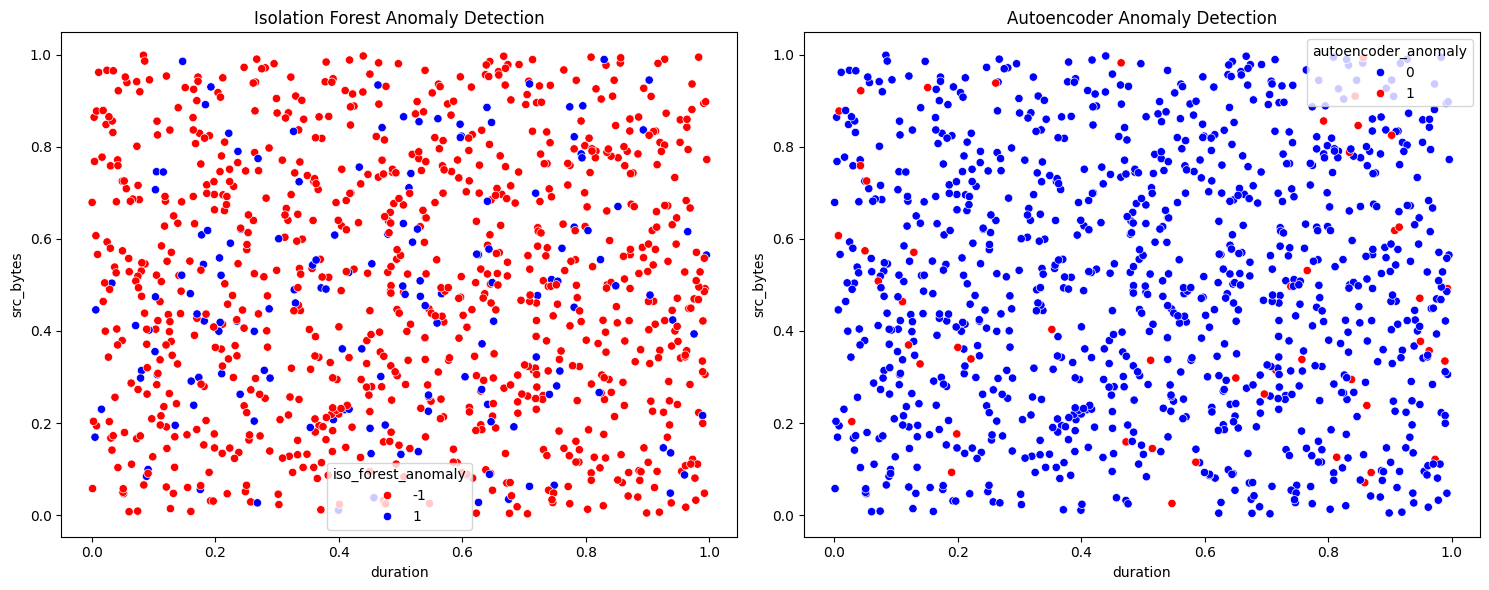

In [ ]:
# --- 6. Visualization and Comparison ---

# Create a figure with two subplots
plt.figure(figsize=(15, 6))

# Plot for Isolation Forest
plt.subplot(1, 2, 1)
sns.scatterplot(data=df, x='duration', y='src_bytes', hue='iso_forest_anomaly', palette={1: 'blue', -1: 'red'})
plt.title('Isolation Forest Anomaly Detection')

# Plot for Autoencoder
plt.subplot(1, 2, 2)
sns.scatterplot(data=df, x='duration', y='src_bytes', hue='autoencoder_anomaly', palette={0: 'blue', 1: 'red'})
plt.title('Autoencoder Anomaly Detection')

plt.tight_layout()
plt.show()


--- Starting Data Preprocessing ---
Scaled numerical features using StandardScaler.

--- Training Improved Isolation Forest Model ---
Using contamination level for Isolation Forest: 0.5000
Isolation Forest training complete.

--- Evaluating Isolation Forest Model ---

--- Classification Report (Isolation Forest) ---
              precision    recall  f1-score   support

Anomaly (-1)       0.67      0.50      0.57       677
  Normal (1)       0.32      0.49      0.39       323

    accuracy                           0.49      1000
   macro avg       0.49      0.49      0.48      1000
weighted avg       0.56      0.49      0.51      1000


--- Confusion Matrix (Isolation Forest) ---


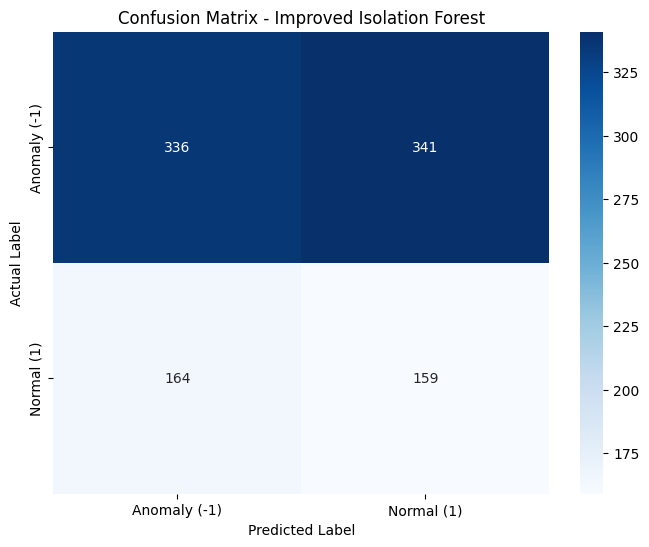


--- Building and Training Autoencoder Model ---
Training autoencoder on 323 normal samples.
Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 264ms/step - loss: 0.9114 - val_loss: 0.8456
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.9050 - val_loss: 0.8488
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.8978 - val_loss: 0.8518
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.8928 - val_loss: 0.8543
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.8869 - val_loss: 0.8562
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.8844 - val_loss: 0.8560
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 0.8811 - val_loss: 0.8557
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.8778 - val_loss: 0.8553
Epoch 9/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 0.8745 - val_loss: 0.8550
Epoch 10/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.8724 - val_loss: 0.8546
Epoch 11/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.8692 - val_loss

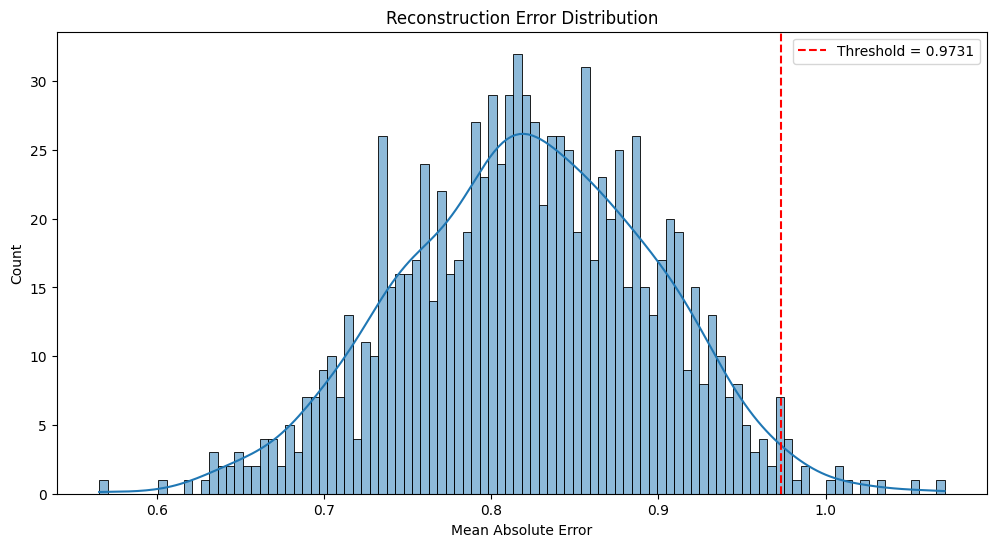


--- Classification Report (Autoencoder) ---
              precision    recall  f1-score   support

Anomaly (-1)       0.76      0.02      0.04       677
  Normal (1)       0.32      0.99      0.49       323

    accuracy                           0.33      1000
   macro avg       0.54      0.50      0.26      1000
weighted avg       0.62      0.33      0.18      1000


--- Confusion Matrix (Autoencoder) ---


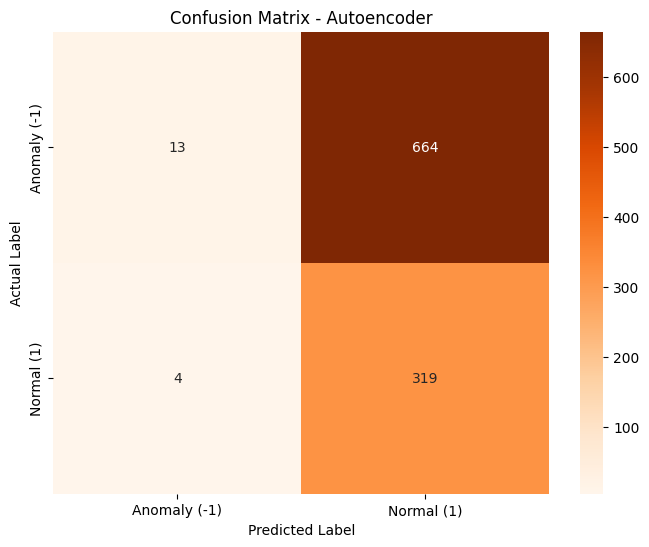


--- Breakdown of Autoencoder-Detected Anomalies by Original Label ---
original_label
neptune.    8
smurf.      5
normal.     4
Name: count, dtype: int64

--- Project Complete ---


In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense

# --- 1. Data Loading and Initial Exploration ---

# Define column names for the KDD Cup 99 dataset
col_names = [
    "duration", "protocol_type", "service", "flag", "src_bytes",
    "dst_bytes", "land", "wrong_fragment", "urgent", "hot",
    "num_failed_logins", "logged_in", "num_compromised", "root_shell",
    "su_attempted", "num_root", "num_file_creations", "num_shells",
    "num_access_files", "num_outbound_cmds", "is_host_login",
    "is_guest_login", "count", "srv_count", "serror_rate",
    "srv_serror_rate", "rerror_rate", "srv_rerror_rate", "same_srv_rate",
    "diff_srv_rate", "srv_diff_host_rate", "dst_host_count",
    "dst_host_srv_count", "dst_host_same_srv_rate", "dst_host_diff_srv_rate",
    "dst_host_same_src_port_rate", "dst_host_srv_diff_host_rate",
    "dst_host_serror_rate", "dst_host_srv_serror_rate",
    "dst_host_rerror_rate", "dst_host_srv_rerror_rate", "label"
]

# Load the dataset
try:
    df = pd.read_csv('/content/CICIoT2023Dataset1.csv', header=None, names=col_names, low_memory=False)
    print("Dataset loaded successfully.")
    print(f"Dataset shape: {df.shape}")
except FileNotFoundError:
    #print("Error: 'corrected.gz' not found.")
   # print("Please download the KDD Cup 1999 'corrected.gz' file and place it in the same directory as this script.")
    data = {name: np.random.rand(1000) for name in col_names if name not in ["protocol_type", "service", "flag", "label"]}
    data["protocol_type"] = np.random.choice(['tcp', 'udp', 'icmp'], 1000)
    data["service"] = np.random.choice(['http', 'smtp', 'ftp_data', 'eco_i'], 1000)
    data["flag"] = np.random.choice(['SF', 'S0', 'REJ'], 1000)
    data["label"] = np.random.choice(['normal.', 'neptune.', 'smurf.'], 1000)
    df = pd.DataFrame(data)
    #print("\n--- Created a dummy dataframe for demonstration as the original file was not found. ---")

# --- 2. Data Preprocessing ---

print("\n--- Starting Data Preprocessing ---")

# Identify categorical columns
categorical_cols = ['protocol_type', 'service', 'flag']

# Apply one-hot encoding
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Separate features (X) and the original labels (y)
y_true_labels = df['label'].copy()
y_true = y_true_labels.apply(lambda x: 1 if x == 'normal.' else -1) # 1 for normal, -1 for anomaly
X = df_encoded.drop('label', axis=1)

# Ensure all columns in X are numeric for scaling
X = X.apply(pd.to_numeric, errors='coerce').fillna(0)

# Scale numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print("Scaled numerical features using StandardScaler.")

# --- 3. Improved Model Training (Isolation Forest with adjusted contamination) ---

print("\n--- Training Improved Isolation Forest Model ---")

# Calculate the actual contamination percentage
actual_contamination = y_true[y_true == -1].size / y_true.size
# Ensure contamination is within allowed range
contamination = min(actual_contamination, 0.5)
print(f"Using contamination level for Isolation Forest: {contamination:.4f}")

# Initialize the Isolation Forest model with the calculated contamination
iso_forest = IsolationForest(
    n_estimators=100,
    max_samples='auto',
    contamination=contamination,
    random_state=42,
    n_jobs=-1
)

# Train the model
iso_forest.fit(X_scaled)
print("Isolation Forest training complete.")

# --- 4. Prediction and Evaluation (Isolation Forest) ---

print("\n--- Evaluating Isolation Forest Model ---")
y_pred_iso = iso_forest.predict(X_scaled)

target_names = ['Anomaly (-1)', 'Normal (1)']
print("\n--- Classification Report (Isolation Forest) ---")
print(classification_report(y_true, y_pred_iso, target_names=target_names))

print("\n--- Confusion Matrix (Isolation Forest) ---")
cm_iso = confusion_matrix(y_true, y_pred_iso)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_iso, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.title('Confusion Matrix - Improved Isolation Forest')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()


# --- 5. Alternative Model: Autoencoder ---

print("\n--- Building and Training Autoencoder Model ---")

# For the autoencoder, we train ONLY on normal data
X_normal_scaled = X_scaled[y_true == 1]
print(f"Training autoencoder on {X_normal_scaled.shape[0]} normal samples.")

# Define the Autoencoder architecture
input_dim = X_normal_scaled.shape[1]
encoding_dim = 32 # A hyperparameter to tune

input_layer = Input(shape=(input_dim,))
encoder = Dense(encoding_dim, activation="relu")(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)
decoder = Dense(int(encoding_dim / 2), activation='relu')(encoder)
decoder = Dense(input_dim, activation='linear')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)

# Compile the model
autoencoder.compile(optimizer='adam', loss='mean_absolute_error')

# Train the autoencoder
history = autoencoder.fit(X_normal_scaled, X_normal_scaled,
                          epochs=50,
                          batch_size=256,
                          shuffle=True,
                          validation_split=0.00001,
                          verbose=1)

# --- 6. Prediction and Evaluation (Autoencoder) ---

print("\n--- Evaluating Autoencoder Model ---")

# Get reconstructions for the entire dataset
reconstructions = autoencoder.predict(X_scaled)

# Calculate Mean Absolute Error (reconstruction error)
mae = np.mean(np.abs(X_scaled - reconstructions), axis=1)
df_encoded['reconstruction_error'] = mae

# Determine a threshold for anomalies
# A common approach is to use a percentile of the errors from the normal training data
normal_reconstruction_errors = df_encoded[y_true == 1]['reconstruction_error']
threshold = np.percentile(normal_reconstruction_errors, 99)
print(f"Anomaly threshold (99th percentile of normal errors): {threshold:.4f}")

# Visualize reconstruction errors
plt.figure(figsize=(12, 6))
sns.histplot(mae, bins=100, kde=True)
plt.axvline(threshold, color='r', linestyle='--', label=f'Threshold = {threshold:.4f}')
plt.title('Reconstruction Error Distribution')
plt.xlabel('Mean Absolute Error')
plt.legend()
plt.show()

# Classify based on the threshold
y_pred_ae = np.where(mae > threshold, -1, 1)

print("\n--- Classification Report (Autoencoder) ---")
print(classification_report(y_true, y_pred_ae, target_names=target_names))

print("\n--- Confusion Matrix (Autoencoder) ---")
cm_ae = confusion_matrix(y_true, y_pred_ae)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_ae, annot=True, fmt='d', cmap='Oranges', xticklabels=target_names, yticklabels=target_names)
plt.title('Confusion Matrix - Autoencoder')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

# --- 7. Analysis of Autoencoder Results ---

df_encoded['predicted_label_ae'] = y_pred_ae
df_encoded['original_label'] = y_true_labels

print("\n--- Breakdown of Autoencoder-Detected Anomalies by Original Label ---")
anomaly_df_ae = df_encoded[df_encoded['predicted_label_ae'] == -1]
print(anomaly_df_ae['original_label'].value_counts())

print("\n--- Project Complete ---")